<a href="https://colab.research.google.com/github/redrabbit329/-Edge-AI-Platform-Tutorials/blob/master/rr___TransferLearning_Project__Yunjeong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Classification System

     [1] 이미지 크롤링, 캐글 Dataset 다운로드로 4종류의 dog 폴더를 생성함
         다운받은 이미지를 dog_image > train 아래 라벨이름으로 저장 압축 후
         Google Drive에 공유한 다음 Colab에서 mount하여 사용한다.
         폴더명은 ImageDataGenerator를 이용하기 위한 구조를 따름

In [ ]:
# 필요한 Library Import
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.applications import MobileNet, Xception, ResNet50, InceptionV3
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Mount Gooble Drive
from google.colab import drive   
drive.mount('/content/gdrive/')  

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# 미리 만들어 둔 파일 다운로드

import shutil
shutil.copy('/content/gdrive/My Drive/Colab Notebooks/dataset/dog_image.zip', '/content/')

'/content/dog_image.zip'

In [ ]:
# root directory 는 코랩의 top folder로 지정
root_dir = '/content'

In [ ]:
import os
import shutil

# 디렉토리가 중복되어 있을 경우 삭제
# Data random shuffle등이 원하는 대로 안되는 경우 또는 백업해야 할 때, 이 코드가 있어야 다시 구글드라이브에서 카피 안해도 재시작가능함
if os.path.exists( os.path.join(root_dir, 'dog_image') ):

    shutil.rmtree( os.path.join(root_dir, 'dog_image') )
    print(os.path.join(root_dir, 'dog_image') + ' is deleted !!')

/content/dog_image is deleted !!


In [ ]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile(os.path.join(root_dir, 'dog_image.zip'), 'r') as target_file:

    target_file.extractall(os.path.join(root_dir, 'dog_image')) 

In [ ]:
# 데이터 전체 개수 확인

import os
import glob

# 데이터 정답 (label) 개수 및 종류 확인

label_name_list = os.listdir(os.path.join(root_dir, 'dog_image/train/'))

print('total label nums = ', len(label_name_list))
print('=================================================')
print(label_name_list)

total label nums =  4
['shepherd', 'chihuahua', 'jindo_dog', 'yorkshire_terrier']


# 작업 2
      [2] test 폴더의 모든 데이터를 test_image_files 폴더로 copy한 후,
          랜덤하게 16개를 선택해서 prediction한다.
          즉, 사용할 폴더 이름은 이에 맞춰 3개를 준비함
          test
          train ( image 압축파일 내 포함 )
          test_image_files

In [ ]:
import os
import shutil

# test, test_image_files 라는 폴더를 생성한다. 없으면 생성
if not os.path.exists(os.path.join(root_dir, 'dog_image/test')):    
    
    os.mkdir(os.path.join(root_dir, 'dog_image/test'))
    print(os.path.join(root_dir, 'dog_image/test') + ' is created !!!')

if not os.path.exists(os.path.join(root_dir, 'dog_image/test_image_files')):    
    
    os.mkdir(os.path.join(root_dir, 'dog_image/test_image_files'))
    print(os.path.join(root_dir, 'dog_image/test_image_files') + ' is created !!!')

# 크롤링한 데이터의 파일명 변경

##### 학습 후 데이터를 선별하거나 테스트, 결과 확인을 위해 파일명을 변경한다.
### 이름은 폴더명 + . + count

In [ ]:
import os

def changeName(path, cName):
  i = 1
  for filename in os.listdir(path):
    print(path+filename, '=> ', path+str(cName)+'.'+str(i)+'.jpg')
    os.rename(path+filename, path+str(cName+'.'+str(i)+'.jpg'))
    i += 1

changeName('dog_image/train/chihuahua/', 'chihuahua')
changeName('dog_image/train/jindo_dog/', 'jindo_dog')
changeName('dog_image/train/shepherd/', 'shepherd')
changeName('dog_image/train/yorkshire_terrier/', 'yorkshire_terrier')

dog_image/train/chihuahua/chihuahua.195.jpg =>  dog_image/train/chihuahua/chihuahua.1.jpg
dog_image/train/chihuahua/chihuahua.49.jpg =>  dog_image/train/chihuahua/chihuahua.2.jpg
dog_image/train/chihuahua/chihuahua.122.jpg =>  dog_image/train/chihuahua/chihuahua.3.jpg
dog_image/train/chihuahua/chihuahua.156.jpg =>  dog_image/train/chihuahua/chihuahua.4.jpg
dog_image/train/chihuahua/chihuahua.135.jpg =>  dog_image/train/chihuahua/chihuahua.5.jpg
dog_image/train/chihuahua/chihuahua.32.jpg =>  dog_image/train/chihuahua/chihuahua.6.jpg
dog_image/train/chihuahua/chihuahua.138.jpg =>  dog_image/train/chihuahua/chihuahua.7.jpg
dog_image/train/chihuahua/chihuahua.117.jpg =>  dog_image/train/chihuahua/chihuahua.8.jpg
dog_image/train/chihuahua/chihuahua.92.jpg =>  dog_image/train/chihuahua/chihuahua.9.jpg
dog_image/train/chihuahua/chihuahua.220.jpg =>  dog_image/train/chihuahua/chihuahua.10.jpg
dog_image/train/chihuahua/chihuahua.30.jpg =>  dog_image/train/chihuahua/chihuahua.11.jpg
dog_image/tr

# train 폴더에서 test 폴더로 move ( ration )
# test 폴더에서 test_image_files 폴더로는 copy

In [ ]:
import os
import glob
import shutil
import random

# 분리 비율
ratio = 0.1    # train : test = 90 : 10

src_root_dir = os.path.join(root_dir,'dog_image/train/')
dst_root_dir = os.path.join(root_dir, 'dog_image/test/')

# train 디렉토리에 먼저 label 디렉토리 생성함

label_name_list = os.listdir(src_root_dir)

count = 0

for label_name in label_name_list:

    dst_label_name_dir = dst_root_dir + label_name

    if not os.path.exists(dst_label_name_dir):
        os.mkdir(dst_label_name_dir)
        print(dst_label_name_dir + ' is created !!')
        count = count + 1

print(len(label_name_list), count)

# 파일 move src dir => dst dir

for label_name in label_name_list:

    train_image_file_list = glob.glob(src_root_dir+label_name+'/*')

    print('========================================================================')
    print('total [%s] image file nums => [%s]' % (label_name ,len(train_image_file_list)))

    # data shuffle
    split_num = int(ratio*len(train_image_file_list))

    print('split nums => ', split_num)

    # extract test data from train data
    test_image_file_list = train_image_file_list[0:split_num]

    move_nums = 0

    for image_file in test_image_file_list:

        shutil.move(image_file, dst_root_dir+label_name)    # move 

        move_nums = move_nums + 1

    print('total move nums => ', move_nums)
    print('========================================================================')

/content/dog_image/test/shepherd is created !!
/content/dog_image/test/chihuahua is created !!
/content/dog_image/test/jindo_dog is created !!
/content/dog_image/test/yorkshire_terrier is created !!
4 4
total [shepherd] image file nums => [198]
split nums =>  19
total move nums =>  19
total [chihuahua] image file nums => [225]
split nums =>  22
total move nums =>  22
total [jindo_dog] image file nums => [99]
split nums =>  9
total move nums =>  9
total [yorkshire_terrier] image file nums => [233]
split nums =>  23
total move nums =>  23


In [ ]:
# train : test 데이터 비율 확인

src_root_dir = os.path.join(root_dir,'dog_image/train/')
dst_root_dir = os.path.join(root_dir, 'dog_image/test/')

train_label_name_list = os.listdir(src_root_dir)
test_label_name_list = os.listdir(src_root_dir)

train_label_name_list.sort()
test_label_name_list.sort()

if train_label_name_list != test_label_name_list:
    print('fatal error !!!!')
else:
    print(len(train_label_name_list), len(test_label_name_list))

# 데이터 개수 확인a

for label_name in train_label_name_list:

    train_data_nums = len(os.listdir(src_root_dir+label_name))
    test_data_nums = len(os.listdir(dst_root_dir+label_name))

    print('train => ', label_name, train_data_nums, ' , test => ', label_name, test_data_nums)
    print('=======================================================')

4 4
train =>  chihuahua 203  , test =>  chihuahua 22
train =>  jindo_dog 90  , test =>  jindo_dog 9
train =>  shepherd 179  , test =>  shepherd 19
train =>  yorkshire_terrier 210  , test =>  yorkshire_terrier 23


# test -> test_image_files 디렉토리로 copy

In [ ]:
import os
import glob
import shutil
import random

src_root_dir = os.path.join(root_dir, 'dog_image/test/')
dst_root_dir = os.path.join(root_dir, 'dog_image/test_image_files/')


label_name_list = os.listdir(src_root_dir)

# 파일 copy src dir => dst dir

for label_name in label_name_list:

    image_file_list = glob.glob(src_root_dir+label_name+'/*')

    print('========================================================================')
    print('total [%s] image file nums => [%s]' % (label_name ,len(train_image_file_list)))

    copy_nums = 0

    for image_file in image_file_list:

        shutil.copy(image_file, dst_root_dir)    # copy 

        copy_nums = copy_nums + 1

    print('total copy nums => ', copy_nums)
    print('========================================================================')

total [shepherd] image file nums => [233]
total copy nums =>  19
total [chihuahua] image file nums => [233]
total copy nums =>  22
total [jindo_dog] image file nums => [233]
total copy nums =>  9
total [yorkshire_terrier] image file nums => [233]
total copy nums =>  23


In [ ]:
# Image Shape Setting : Accuracy and Learning time tradeoff
IMG_WIDTH = 224  # 150
IMG_HEIGHT = 224  # 150

# ImageDataGenerator 
      validation은 ImageDataGenerator로 split 한다.
      validation_split 비율은 0.15로 

In [ ]:
# ImageDataGenerator Setting
train_dir = os.path.join(root_dir, 'dog_image/train/')

validation_dir = os.path.join(root_dir, 'dog_image/train/')

test_dir = os.path.join(root_dir, 'dog_image/test/')

In [ ]:
# ImageDataGenerator 이용하여 데이터 불러옴 ( validation_split )

train_datagen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    validation_split=0.15)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                batch_size=16, 
                                                color_mode='rgb', 
                                                class_mode='sparse',
                                                subset = 'training',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))


validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                          batch_size=16, 
                                                          color_mode='rgb', 
                                                          class_mode='sparse',
                                                          subset = 'validation',
                                                          target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 582 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [ ]:
# 정답 확인

print(train_generator.class_indices)

print(len(train_generator.classes))
print(len(validation_generator.classes))

print(train_generator.num_classes)
print(validation_generator.num_classes)

{'chihuahua': 0, 'jindo_dog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}
582
100
4
4


# Transfer Learning Base Model Construction

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

In [ ]:
model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))                  # Dropout(0.5) 오버피팅 발생함
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                1605664   
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4,834,660
Trainable params: 4,812,772
Non-trainable params: 21,888
_______________________________________

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])  # lr ration 주의

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

save_file_name = './MyDogClassification_MobileNet_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,       # file명을 지정
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출
                             verbose=1,            # 로그를 출력
                             save_best_only=True,  # 가장 best 값만 저장
                             mode='auto'           
                            )

earlystopping = EarlyStopping(monitor='val_loss', # 모니터 기준 설정 (val loss) 
                              patience=5,        # 5회 Epoch동안 개선되지 않는다면 종료  
                              restore_best_weights=True,
                              verbose=1                            
                             )

start_time = datetime.now()

hist = model.fit(train_generator, epochs=50, 
                 validation_data=validation_generator,
                 callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

Epoch 1/50
37/37 [==============================] - ETA: 0s - loss: 1.6532 - accuracy: 0.3918
Epoch 1: val_loss improved from inf to 0.88631, saving model to ./MyDogClassification_MobileNet_Colab.h5
37/37 [==============================] - 15s 324ms/step - loss: 1.6532 - accuracy: 0.3918 - val_loss: 0.8863 - val_accuracy: 0.6900
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 0.8802 - accuracy: 0.6409
Epoch 2: val_loss improved from 0.88631 to 0.56046, saving model to ./MyDogClassification_MobileNet_Colab.h5
37/37 [==============================] - 11s 304ms/step - loss: 0.8802 - accuracy: 0.6409 - val_loss: 0.5605 - val_accuracy: 0.7900
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.7027
Epoch 3: val_loss improved from 0.56046 to 0.30789, saving model to ./MyDogClassification_MobileNet_Colab.h5
37/37 [==============================] - 11s 305ms/step - loss: 0.7315 - accuracy: 0.7027 - val_loss: 0.3079 - val_accuracy: 0.9200

In [ ]:
best_model = tf.keras.models.load_model('./MyDogClassification_MobileNet_Colab.h5')

In [ ]:
#from google.colab import files

#files.download('MyDogClassification_MobileNet_Colab.h5')

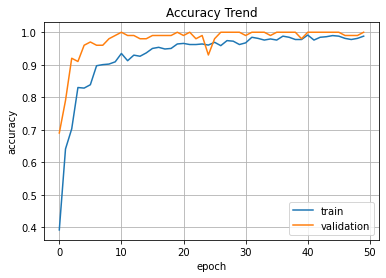

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

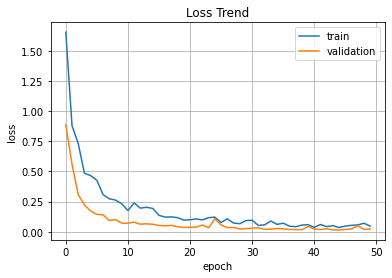

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 73 images belonging to 4 classes.


In [ ]:
model.evaluate(test_generator)

3/3 [==============================] - 0s 122ms/step - loss: 0.3348 - accuracy: 0.9589


[0.3347674310207367, 0.9589040875434875]

In [ ]:
import random
import os
import numpy as np
import cv2
import glob

label_dict = {'chihuahua': 0, 'jindo_dog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}

test_image_files_list = glob.glob(root_dir+ '/dog_image/test_image_files/*.jpg')

random.shuffle(test_image_files_list)


# 파일형식은 정답.숫자.jpg 이므로 정답을 분리할수 있다

test_num = 16

test_image_files = test_image_files_list[:test_num]

print(test_image_files)

label_list = []

for i in range(len(test_image_files)):

    label = test_image_files[i].split('/')[-1].split('.')[0].strip()

    label_list.append(label_dict[label])

print(label_list)

# 이미지 파일 읽어옴

src_img_list = []


for i in range(len(test_image_files)):

    src_img = cv2.imread(test_image_files[i], cv2.IMREAD_COLOR)

    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    src_img = src_img / 255.0

    src_img_list.append(src_img)

['/content/dog_image/test_image_files/shepherd.106.jpg', '/content/dog_image/test_image_files/yorkshire_terrier.118.jpg', '/content/dog_image/test_image_files/shepherd.180.jpg', '/content/dog_image/test_image_files/shepherd.96.jpg', '/content/dog_image/test_image_files/shepherd.126.jpg', '/content/dog_image/test_image_files/shepherd.123.jpg', '/content/dog_image/test_image_files/shepherd.21.jpg', '/content/dog_image/test_image_files/chihuahua.127.jpg', '/content/dog_image/test_image_files/yorkshire_terrier.101.jpg', '/content/dog_image/test_image_files/yorkshire_terrier.132.jpg', '/content/dog_image/test_image_files/jindo_dog.85.jpg', '/content/dog_image/test_image_files/yorkshire_terrier.44.jpg', '/content/dog_image/test_image_files/yorkshire_terrier.207.jpg', '/content/dog_image/test_image_files/jindo_dog.70.jpg', '/content/dog_image/test_image_files/shepherd.177.jpg', '/content/dog_image/test_image_files/jindo_dog.17.jpg']
[2, 3, 2, 2, 2, 2, 2, 0, 3, 3, 1, 3, 3, 1, 2, 1]


In [ ]:
import random
import os
import numpy as np
import cv2
import glob

label_dict = {'chihuahua': 0, 'jindo_dog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}

test_image_files_list = glob.glob(root_dir+ '/dog_image/test_image_files/*.jpg')

random.shuffle(test_image_files_list)



# 파일형식은 정답.숫자.jpg 이므로 정답을 분리할수 있다

test_num = 16

test_image_files = test_image_files_list[:test_num]

print(test_image_files)

label_list = []

for i in range(len(test_image_files)):

    label = test_image_files[i].split('/')[-1].split('.')[0].strip()

    label_list.append(label_dict[label])

print(label_list)

# 이미지 파일 읽어옴

src_img_list = []

for i in range(len(test_image_files)):

    src_img = cv2.imread(test_image_files[i], cv2.IMREAD_COLOR)

    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    src_img = src_img / 255.0

    src_img_list.append(src_img)

# 4차원 텐서  변환

src_img_array = np.array(src_img_list)
label_array = np.array(label_list)

print(src_img_array.shape, label_array.shape)

print(label_array)

['/content/dog_image/test_image_files/chihuahua.86.jpg', '/content/dog_image/test_image_files/chihuahua.154.jpg', '/content/dog_image/test_image_files/shepherd.96.jpg', '/content/dog_image/test_image_files/chihuahua.202.jpg', '/content/dog_image/test_image_files/shepherd.27.jpg', '/content/dog_image/test_image_files/yorkshire_terrier.101.jpg', '/content/dog_image/test_image_files/chihuahua.37.jpg', '/content/dog_image/test_image_files/chihuahua.219.jpg', '/content/dog_image/test_image_files/yorkshire_terrier.213.jpg', '/content/dog_image/test_image_files/shepherd.31.jpg', '/content/dog_image/test_image_files/jindo_dog.85.jpg', '/content/dog_image/test_image_files/yorkshire_terrier.169.jpg', '/content/dog_image/test_image_files/jindo_dog.80.jpg', '/content/dog_image/test_image_files/yorkshire_terrier.67.jpg', '/content/dog_image/test_image_files/chihuahua.47.jpg', '/content/dog_image/test_image_files/yorkshire_terrier.230.jpg']
[0, 0, 2, 0, 2, 3, 0, 0, 3, 2, 1, 3, 1, 3, 0, 3]
(16, 224, 

In [ ]:
best_pred = best_model.predict(src_img_array)

pred = model.predict(src_img_array)

print(best_pred.shape, pred.shape)

(16, 4) (16, 4)


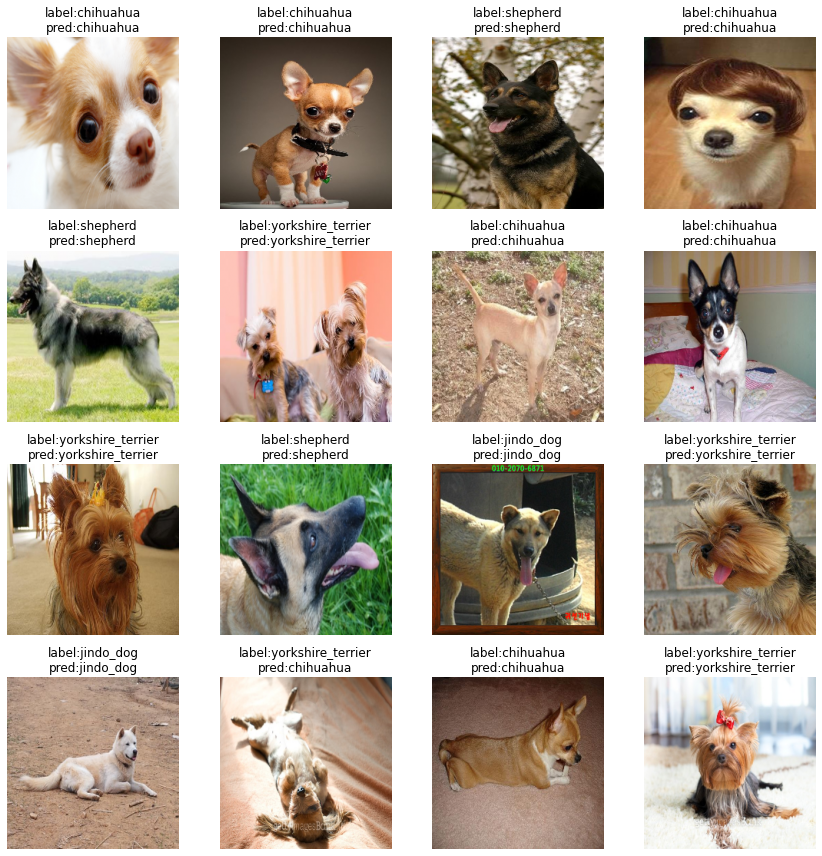

In [ ]:
import matplotlib.pyplot as plt

class_names = ['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']

plt.figure(figsize=(12,12))

for pos in range(len(best_pred)):

    plt.subplot(4,4,pos+1)
    plt.axis('off')

    label_str = class_names[label_array[pos]]
    pred_str = class_names[np.argmax(best_pred[pos])]

    plt.title('label:' + label_str + '\npred:' + pred_str)

    plt.imshow(src_img_array[pos])

plt.tight_layout()
plt.show()

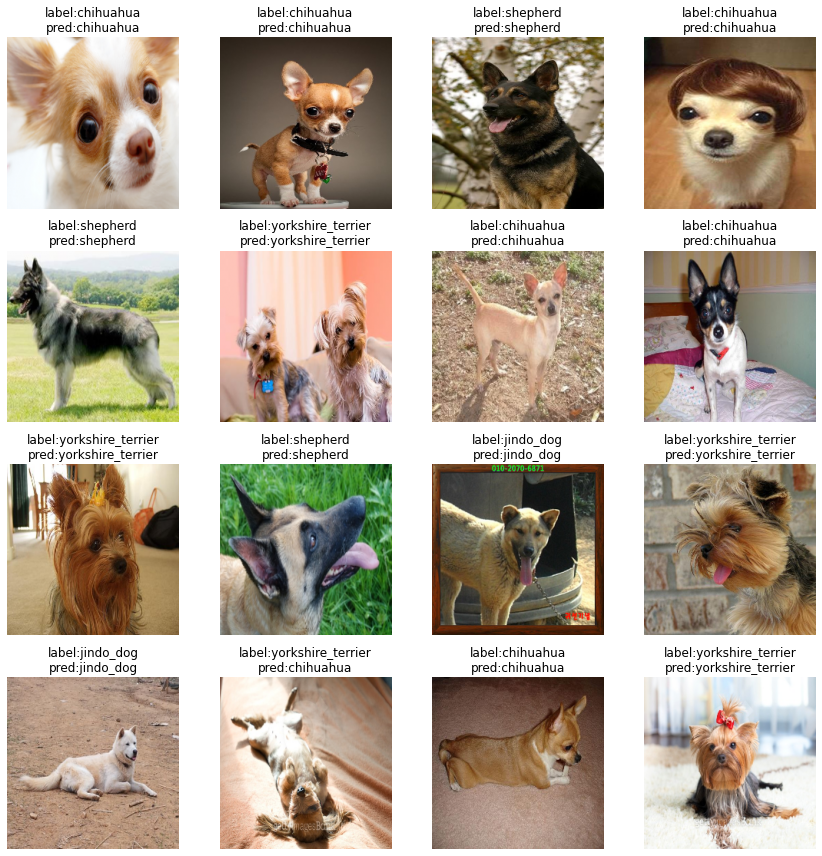

In [ ]:
import matplotlib.pyplot as plt

class_names = ['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']

plt.figure(figsize=(12,12))

for pos in range(len(pred)):

    plt.subplot(4,4,pos+1)
    plt.axis('off')

    label_str = class_names[label_array[pos]]
    pred_str = class_names[np.argmax(pred[pos])]

    plt.title('label:' + label_str + '\npred:' + pred_str)

    plt.imshow(src_img_array[pos])

plt.tight_layout()
plt.show()

# 개별 이미지 테스트

In [ ]:
import cv2

# Image Shape Setting : Accuracy and Learning time tradeoff
IMG_WIDTH = 224  # 150
IMG_HEIGHT = 224  # 150

# 개별 이미지 테스트

ppoppy_list = []
print(ppoppy_list)

 
ppoppy1 = cv2.imread(os.path.join(root_dir, 'dog_image/test_image_files/yorkshire_terrier.101.jpg'), cv2.IMREAD_COLOR)
ppoppy1 = cv2.resize(ppoppy1, dsize=(IMG_WIDTH, IMG_HEIGHT))
ppoppy1 = cv2.cvtColor(ppoppy1, cv2.COLOR_BGR2RGB)
ppoppy1 = ppoppy1 / 255.0

ppoppy2 = cv2.imread(os.path.join(root_dir, 'dog_image/test_image_files/yorkshire_terrier.103.jpg'), cv2.IMREAD_COLOR)
ppoppy2 = cv2.resize(ppoppy2, dsize=(IMG_WIDTH, IMG_HEIGHT))
ppoppy2 = cv2.cvtColor(ppoppy2, cv2.COLOR_BGR2RGB)
ppoppy2 = ppoppy2 / 255.0

ppoppy3 = cv2.imread(os.path.join(root_dir, 'dog_image/test_image_files/yorkshire_terrier.118.jpg'), cv2.IMREAD_COLOR)
ppoppy3 = cv2.resize(ppoppy3, dsize=(IMG_WIDTH, IMG_HEIGHT))
ppoppy3 = cv2.cvtColor(ppoppy3, cv2.COLOR_BGR2RGB)
ppoppy3 = ppoppy3 / 255.0

ppoppy_list.append(ppoppy1)
ppoppy_list.append(ppoppy2)
ppoppy_list.append(ppoppy3)

ppoppy_array = np.array(ppoppy_list)

print(ppoppy_array.shape)

[]
(3, 224, 224, 3)


In [ ]:
ppoppy_pred = model.predict(ppoppy_array)

ppoppy_best_pred = best_model.predict(ppoppy_array)

print(ppoppy_pred.shape, ppoppy_best_pred.shape)

(3, 4) (3, 4)


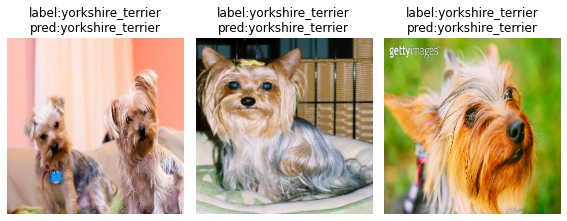

In [ ]:
import matplotlib.pyplot as plt

class_names = class_names = ['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']

plt.figure(figsize=(8,8))

for pos in range(len(ppoppy_pred)):

    plt.subplot(1,3,pos+1)
    plt.axis('off')

    label_str = 'yorkshire_terrier'
    pred_str = class_names[np.argmax(ppoppy_pred[pos])]

    plt.title('label:' + label_str + '\npred:' + pred_str)

    plt.imshow(ppoppy_array[pos])

plt.tight_layout()
plt.show()

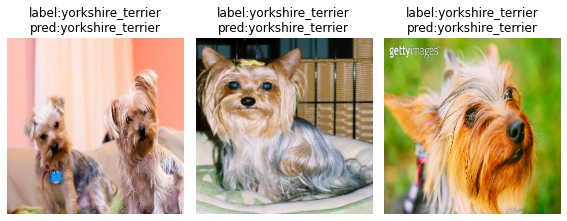

In [ ]:
import matplotlib.pyplot as plt

class_names = class_names = ['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']

plt.figure(figsize=(8,8))

for pos in range(len(ppoppy_best_pred)):

    plt.subplot(1,3,pos+1)
    plt.axis('off')

    label_str = 'yorkshire_terrier'
    pred_str = class_names[np.argmax(ppoppy_best_pred[pos])]

    plt.title('label:' + label_str + '\npred:' + pred_str)

    plt.imshow(ppoppy_array[pos])

plt.tight_layout()
plt.show()

In [ ]:
print(ppoppy_pred)

[[2.7452290e-12 6.1759181e-19 9.0087163e-15 1.0000000e+00]
 [6.9430519e-09 1.9769889e-13 2.3669922e-11 1.0000000e+00]
 [3.8747284e-08 8.4046187e-11 1.1173903e-06 9.9999893e-01]]


In [ ]:
print(ppoppy_best_pred)

[[2.7452290e-12 6.1759181e-19 9.0087163e-15 1.0000000e+00]
 [6.9430519e-09 1.9769889e-13 2.3669922e-11 1.0000000e+00]
 [3.8747284e-08 8.4046187e-11 1.1173903e-06 9.9999893e-01]]
